<a href="https://www.kaggle.com/code/sarath02003/face-recognition-using-vgg16-an-vgg19-with-tpu?scriptVersionId=175191480" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
pip install --upgrade tensorflow keras

In [2]:
import tensorflow as tf
import keras
print(keras.__version__) #2.16.1
print(tf.__version__) #3.2.1

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.13.1
2.13.0


# Model-1 (Training on Entire Image)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# suppress display of warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Set your train_dir path
train_dir = '/kaggle/input/face-recognition-dataset/Original Images/Original Images'

In [5]:
# Using ImageDataGenerator for data augmentation
generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,             # Shear transformation
    zoom_range=0.2,               # Random zoom
    rotation_range=20,            # Random rotation in the range [-20, 20] degrees
    width_shift_range=0.1,        # Random horizontal shift
    height_shift_range=0.1,       # Random vertical shift
    horizontal_flip=True,        # Random horizontal flip
    vertical_flip=True,          # Random vertical flip
    brightness_range=[0.8, 1.2],  # Random brightness adjustment
    validation_split=0.1          # 10% of the data will be used for validation
)

In [6]:
# Load and split the data into training and validation sets
train_ds = generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    subset="training"  # This is for training data
)

Found 2318 images belonging to 31 classes.


In [7]:
val_ds = generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    subset="validation"  # This is for validation data
)

Found 244 images belonging to 31 classes.


In [8]:
# Get the list of classes
classes = list(train_ds.class_indices.keys())
print(classes)

['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma', 'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron', 'Claire Holt', 'Courtney Cox', 'Dwayne Johnson', 'Elizabeth Olsen', 'Ellen Degeneres', 'Henry Cavill', 'Hrithik Roshan', 'Hugh Jackman', 'Jessica Alba', 'Kashyap', 'Lisa Kudrow', 'Margot Robbie', 'Marmik', 'Natalie Portman', 'Priyanka Chopra', 'Robert Downey Jr', 'Roger Federer', 'Tom Cruise', 'Vijay Deverakonda', 'Virat Kohli', 'Zac Efron']


# VGG16 

In [ ]:
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import VGG16

IMAGE_SIZE = [224, 224]  # we will keep the image size as (64,64). You can increase the size for better results. 

# loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

# this will exclude the initial layers from the training phase as they have already been trained.
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(4096, activation='relu')(x)   
x = Dropout(0.5)(x)
x = Dense(1023, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(31, activation='softmax')(x) 
model = Model(inputs = vgg.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'],steps_per_execution=32)
print("model created")

# VGG19

In [9]:
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import VGG19

IMAGE_SIZE = [224, 224]  # we will keep the image size as (64,64). You can increase the size for better results. 

# loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
vgg = VGG19(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

# this will exclude the initial layers from the training phase as they have already been trained.
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(4096, activation='relu')(x)   
x = Dropout(0.5)(x)
x = Dense(1023, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(31, activation='softmax')(x) 
model = Model(inputs = vgg.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'],steps_per_execution=32)
print("model created")

80134624/80134624 [==============================] - 0s 0us/step
model created


# VGG16 with TPU

In [ ]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    # importing the libraries
    from keras.models import Model
    from keras.layers import Flatten, Dense
    from keras.applications import VGG16

    IMAGE_SIZE = [224, 224]  # we will keep the image size as (64,64). You can increase the size for better results. 

    # loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
    vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

    # this will exclude the initial layers from the training phase as they have already been trained.
    for layer in vgg.layers:
        layer.trainable = False

    x = Flatten()(vgg.output)
    x = Dense(2046, activation='relu')(x)   
    x = Dropout(0.8)(x)
    x = Dense(1023, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(31, activation='softmax')(x) 
    model = Model(inputs = vgg.input, outputs = x)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'],steps_per_execution=32)
    print("model created")

# ResNet50

In [ ]:
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import ResNet50

IMAGE_SIZE = [224, 224]  # we will keep the image size as (128, 128). You can adjust it as needed.

# loading the weights of ResNet101 without the top layer. These weights are trained on Imagenet dataset.
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# this will exclude the initial layers from the training phase as they have already been trained.
for layer in resnet.layers:
    layer.trainable = False

x = Flatten()(resnet.output)
x = Dense(4096, activation='relu')(x)   
x = Dropout(0.7)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)  # adding the output layer with softmax activation
x = Dense(31, activation='softmax')(x)  # adding the output layer with softmax activation

model = Model(inputs=resnet.input, outputs=x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], steps_per_execution=32)
print("Model created")

# ResNet101 with TPU

In [ ]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    # importing the libraries
    from keras.models import Model
    from keras.layers import Flatten, Dense
    from keras.applications import ResNet101

    IMAGE_SIZE = [128, 128]  # we will keep the image size as (128, 128). You can adjust it as needed.

    # loading the weights of ResNet101 without the top layer. These weights are trained on Imagenet dataset.
    resnet = ResNet101(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

    # this will exclude the initial layers from the training phase as they have already been trained.
    for layer in resnet.layers:
        layer.trainable = False

    x = Flatten()(resnet.output)
    x = Dense(2046, activation='relu')(x)   # you can add additional fully connected layers if needed
    x = Dropout(0.8)(x)
    x = Dense(1023, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(31, activation='softmax')(x)  # adding the output layer with softmax activation

    model = Model(inputs=resnet.input, outputs=x)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], steps_per_execution=32)
    print("Model created")


# Model training

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# BATCH_SIZE = 8 * tpu_strategy.num_replicas_in_sync #using tpu
BATCH_SIZE = 128
print(BATCH_SIZE)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_ds, epochs=30, validation_data=val_ds, 
                    batch_size=BATCH_SIZE,  
                    callbacks=[early_stopping],
                    verbose=1)

32
Epoch 1/30
73/73 [==============================] - 111s 2s/step - loss: 6.1360 - accuracy: 0.0354 - val_loss: 3.4105 - val_accuracy: 0.0574
Epoch 2/30
73/73 [==============================] - 70s 965ms/step - loss: 3.4460 - accuracy: 0.0453 - val_loss: 3.3197 - val_accuracy: 0.0861
Epoch 3/30
73/73 [==============================] - 72s 992ms/step - loss: 3.3947 - accuracy: 0.0569 - val_loss: 3.2990 - val_accuracy: 0.0820
Epoch 4/30
73/73 [==============================] - 73s 998ms/step - loss: 3.3498 - accuracy: 0.0699 - val_loss: 3.1940 - val_accuracy: 0.0574
Epoch 5/30
73/73 [==============================] - 73s 999ms/step - loss: 3.2504 - accuracy: 0.0815 - val_loss: 3.0922 - val_accuracy: 0.1025
Epoch 6/30
73/73 [==============================] - 70s 964ms/step - loss: 3.1948 - accuracy: 0.0889 - val_loss: 3.1624 - val_accuracy: 0.1189
Epoch 7/30
73/73 [==============================] - 71s 970ms/step - loss: 3.1715 - accuracy: 0.0880 - val_loss: 3.1561 - val_accuracy: 0.155

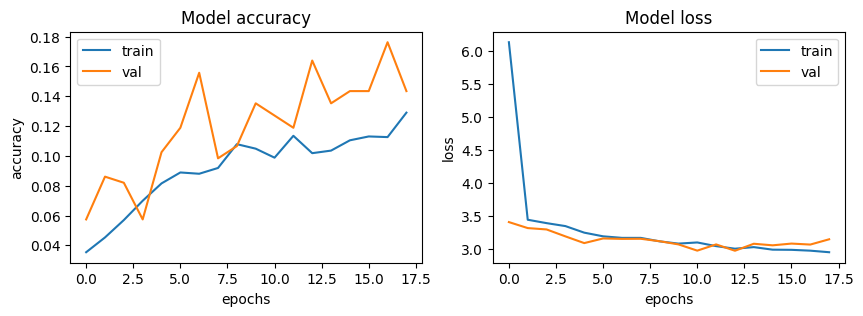

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [13]:
train_loss, train_accuracy = model.evaluate(train_ds)
print(f"Training Accuracy: {train_accuracy*100: .2f}%")

73/73 [==============================] - 63s 860ms/step - loss: 2.8182 - accuracy: 0.1756
Training Accuracy:  17.56%


In [15]:
validation_loss, validation_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {train_accuracy*100: .2f}%")

8/8 [==============================] - 7s 917ms/step - loss: 2.9963 - accuracy: 0.1598
Validation Accuracy:  17.56%


In [16]:
# Evaluate the model on the test set
test_ds = generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    subset="validation"  # Use a portion of the data for testing
)

Found 244 images belonging to 31 classes.


In [17]:
# Get accuracy on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

8/8 [==============================] - 7s 925ms/step - loss: 2.9686 - accuracy: 0.1516
Test Accuracy: 15.16%


In [ ]:
model.save('FRM.h5')
from IPython.display import FileLink

# Create a download link
FileLink('FRM.h5')

# Model-2 (Face Cropped & Splited Dataset)

In [18]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# suppress display of warnings
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Get the directory containing Haar cascade files
cascade_dir = cv2.data.haarcascades

# Path to the Haar cascade file for frontal face detection
cascade_file = os.path.join(cascade_dir, 'haarcascade_frontalface_default.xml')

# Check if the cascade file exists
if os.path.isfile(cascade_file):
    print("Haar cascade file found:", cascade_file)
else:
    print("Haar cascade file not found. Downloading...")
    cv2_base_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/"
    cascade_url = cv2_base_url + 'haarcascade_frontalface_default.xml'
    os.system(f"wget {cascade_url} -P {cascade_dir}")
    print("Haar cascade file downloaded successfully.")

# Now, you can use cascade_file as the filter_path in your code.
filter_path = cascade_file

Haar cascade file found: /opt/conda/lib/python3.10/site-packages/cv2/data/haarcascade_frontalface_default.xml


In [20]:
# Function to detect faces and crop them from an image
def detect_and_crop_faces(image):
    face_cascade = cv2.CascadeClassifier(filter_path)
    faces = face_cascade.detectMultiScale(image, 1.3, 5)
    cropped_faces = []
    for (x, y, w, h) in faces:
        cropped_faces.append(image[y:y+h, x:x+w])
    return cropped_faces


In [21]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Path to the dataset directory
dataset_dir = "/kaggle/input/face-recognition-dataset/Original Images/Original Images"
# Path to store the cropped images
cropped_dataset_dir = "/kaggle/working/CroppedImages"
# Path to store the split train and test sets
train_dir = os.path.join(cropped_dataset_dir, "train")
test_dir = os.path.join(cropped_dataset_dir, "test")

# Create directories for train and test sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Common size to which all face images will be resized
common_size = (128, 128)

# Iterate through each subdirectory (each person's folder)
for subdir in os.listdir(dataset_dir):
    subdir_path = os.path.join(dataset_dir, subdir)
    if os.path.isdir(subdir_path):
        # Create corresponding subdirectories in train and test folders
        train_subdir_path = os.path.join(train_dir, subdir)
        test_subdir_path = os.path.join(test_dir, subdir)
        os.makedirs(train_subdir_path, exist_ok=True)
        os.makedirs(test_subdir_path, exist_ok=True)

        # Get the list of image files in the subdirectory
        image_files = [f for f in os.listdir(subdir_path) if f.endswith('.jpg')]

        # Iterate through each image in the subdirectory
        for image_name in image_files:
            image_path = os.path.join(subdir_path, image_name)
            # Read the image
            img = cv2.imread(image_path)
            # Detect and crop faces from the image (function detect_and_crop_faces to be defined)
            faces = detect_and_crop_faces(img)
            # Resize each face to a common size before appending to the list
            for idx, face in enumerate(faces):
                if face is not None:
                    resized_face = cv2.resize(face, common_size)
                    # Decide whether to put the image in train or test set
                    if np.random.rand() < 0.9:  # 90% train, 10% test
                        save_path = os.path.join(train_subdir_path, f"{image_name}_{idx}.jpg")
                    else:
                        save_path = os.path.join(test_subdir_path, f"{image_name}_{idx}.jpg")
                    # Save the cropped face image
                    cv2.imwrite(save_path, resized_face)
print('dataset created')

dataset created


In [24]:
import zipfile
import os

def zip_folder(folder_path, output_path):
    """
    Zip the contents of a folder.

    Args:
        folder_path (str): Path to the folder to be zipped.
        output_path (str): Path to save the zip file.
    """
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.dirname(folder_path))
                zipf.write(file_path, arcname)

# Example usage
folder_to_zip = '/kaggle/working/CroppedImages'
output_zip_file = '/kaggle/working/output.zip'

zip_folder(folder_to_zip, output_zip_file)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
img = mpimg.imread('/kaggle/working/CroppedImages/train/Elizabeth Olsen/Elizabeth Olsen_64.jpg_0.jpg')
imgplot = plt.imshow(img)

In [ ]:
!pip install anytree

In [ ]:
import os
from anytree import Node, RenderTree

def create_directory_tree(root_path, parent=None):
    """
    Recursively create a directory tree structure using AnyTree.
    """
    node = Node(os.path.basename(root_path), parent=parent)
    if os.path.isdir(root_path):
        for item in sorted(os.listdir(root_path)):
            item_path = os.path.join(root_path, item)
            create_directory_tree(item_path, parent=node)

def print_directory_tree(root_path):
    """
    Print the directory tree structure using AnyTree.
    """
    root = Node(os.path.basename(root_path))
    create_directory_tree(root_path, root)
    for pre, _, node in RenderTree(root):
        print("%s%s" % (pre, node.name))

# Define the root directory
root_dir = "/kaggle/working/CroppedImages"

# Print the directory tree
print_directory_tree(root_dir)

In [ ]:
train_dir = '/kaggle/working/CroppedImages/train'
test_dir = '/kaggle/working/CroppedImages/test'

# Using ImageDataGenerator for data augmentation
generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1  # 10% of the data will be used for validation
)

# Load and split the data into training and validation sets
train_ds = generator.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    subset="training"  # This is for training data
)

val_ds = generator.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    subset="validation"  # This is for validation data
)

# Get the list of classes
classes = list(train_ds.class_indices.keys())
print("Classes in training data:", classes)
print(f'length of classes:{len(classes)}')

# Load test data
test_ds = generator.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    subset="training"  # This is for test data
)

# Get the list of classes in test data
test_classes = list(test_ds.class_indices.keys())
print("Classes in test data:", test_classes)


In [ ]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
#     # importing the librariesṇ
#     from keras.models import Model
#     from keras.layers import Flatten, Dense
#     from keras.applications import VGG16

#     IMAGE_SIZE = [128, 128]  # we will keep the image size as (64,64). You can increase the size for better results. 

#     # loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
#     vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

#     # this will exclude the initial layers from the training phase as they have already been trained.
#     for layer in vgg.layers:
#         layer.trainable = False

#     x = Flatten()(vgg.output)
#     #x = Dense(128, activation = 'relu')(x)   # we can add a new fully connected layer but it will increase the execution time.
#     x = Dense(31, activation = 'softmax')(x)  # adding the output layer with softmax function as this is a multi-label classification problem.

#     model = Model(inputs = vgg.input, outputs = x)

#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #filters= the depth of output image or kernels
    import keras
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
    from keras.optimizers import Adam
    from keras.callbacks import TensorBoard

    im_shape = (128, 128, 3)
    num_classes = 31

    model = Sequential([
        Conv2D(filters=36, kernel_size=7, activation='relu', input_shape=im_shape),
        MaxPooling2D(pool_size=2),
        Conv2D(filters=54, kernel_size=5, activation='relu'),
        MaxPooling2D(pool_size=2),
        Flatten(),
        Dense(2024, activation='relu'),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Output layer with softmax activation
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    print("model created")

In [ ]:
model.summary()

In [ ]:
BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync
history = model.fit(train_ds, epochs=10, validation_data=val_ds, batch_size=BATCH_SIZE)

In [ ]:
train_loss, train_accuracy = model.evaluate(train_ds)
print(f"Training Accuracy: {train_accuracy*100: .2f}")

In [ ]:
validation_loss, validation_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {train_accuracy*100: .2f}")

In [ ]:
# Evaluate the model on the test set
test_ds = generator.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    subset="validation"  # Use a portion of the data for testing
)

In [ ]:
# Get accuracy on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# Plot the training and validation accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])